In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedKFold, cross_validate, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from sklearn.metrics import PredictionErrorDisplay

In [29]:
import sklearn
sklearn.__version__

'1.5.1'

## Датасет

В вашем распоряжении имеются данные из National Longitudinal Survey. Они представляют собой выборку 
из 545 американских работников-мужчин, которые закончили свое обучение в 1980 году, а затем работали в течение 1980-1987 годов. Все мужчины в выборке по состоянию на начало исследования (1980 год) были в возрасте c 17 до 23 лет. 

Данные содержатся в файле `males_wage.csv`.
1. id — номер работника;
2. Years — год;
3. School — количество лет обучения;
4. Expert — опыт работы;
5. Union — фиктивная переменная, равная единице, если данный работник в данном году состоял в профсоюзе;
6. Married — фиктивная переменная, равная единице, если данный работник в данном году состоял в браке;
7. Black — фиктивная переменная, равная единице для афроамериканцев;
8. Hisp — фиктивная переменная, равная единице для латиноамериканцев;
9. Wage — логарифм заработной платы.

Вам необходимо ответить на следующий вопрос: как факт участия в профсоюзе сказывается на заработной плате (количественно)? Иными словами, верно ли, что работники, состоящие в профсоюзе, получают больше по сравнению со всеми остальными и насколько?

In [32]:
pd.read_csv('dataset/males_wage.csv').head(2)

,Unnamed: 0,id,Years,School,Expert,Union,Married,Black,Hisp,Wage
0,0,13.0,1982.0,14.0,3.0,0.0,0.0,0.0,0.0,1.344462
1,1,13.0,1981.0,14.0,2.0,1.0,0.0,0.0,0.0,1.853060


In [34]:
df = pd.read_csv('dataset/males_wage.csv', index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4360 entries, 0 to 4359
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       4360 non-null   float64
 1   Years    4360 non-null   float64
 2   School   4360 non-null   float64
 3   Expert   4360 non-null   float64
 4   Union    4360 non-null   float64
 5   Married  4360 non-null   float64
 6   Black    4360 non-null   float64
 7   Hisp     4360 non-null   float64
 8   Wage     4360 non-null   float64
dtypes: float64(9)
memory usage: 340.6 KB


In [36]:
males = df.drop(['id'], axis=1)
males.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Years,4360.0,1983.500000,2.291551,1980.000000,1981.750000,1983.500000,1985.250000,1987.00000
School,4360.0,11.766972,1.746181,3.000000,11.000000,12.000000,12.000000,16.00000
Expert,4360.0,6.514679,2.825873,0.000000,4.000000,6.000000,9.000000,18.00000
Union,4360.0,0.244037,0.429564,0.000000,0.000000,0.000000,0.000000,1.00000
Married,4360.0,0.438991,0.496321,0.000000,0.000000,0.000000,1.000000,1.00000
Black,4360.0,0.115596,0.319777,0.000000,0.000000,0.000000,0.000000,1.00000
Hisp,4360.0,0.155963,0.362862,0.000000,0.000000,0.000000,0.000000,1.00000
Wage,4360.0,1.649147,0.532609,-3.579079,1.350717,1.671143,1.991086,4.05186


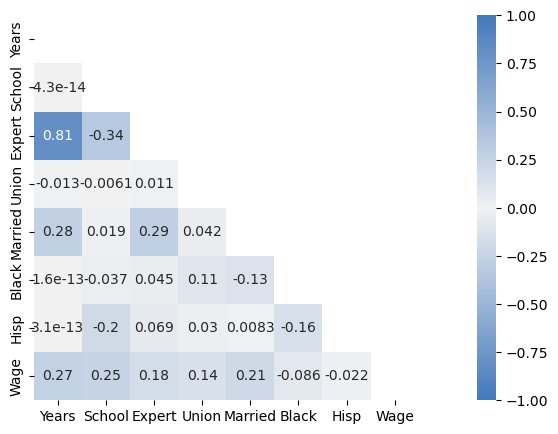

In [38]:
corr = males.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(corr,
    mask=mask,
    cmap=sns.diverging_palette(250, 250, as_cmap=True),
    annot = True,
    vmin=-1.0, vmax=1.0,
    square=True,
    ax=ax);

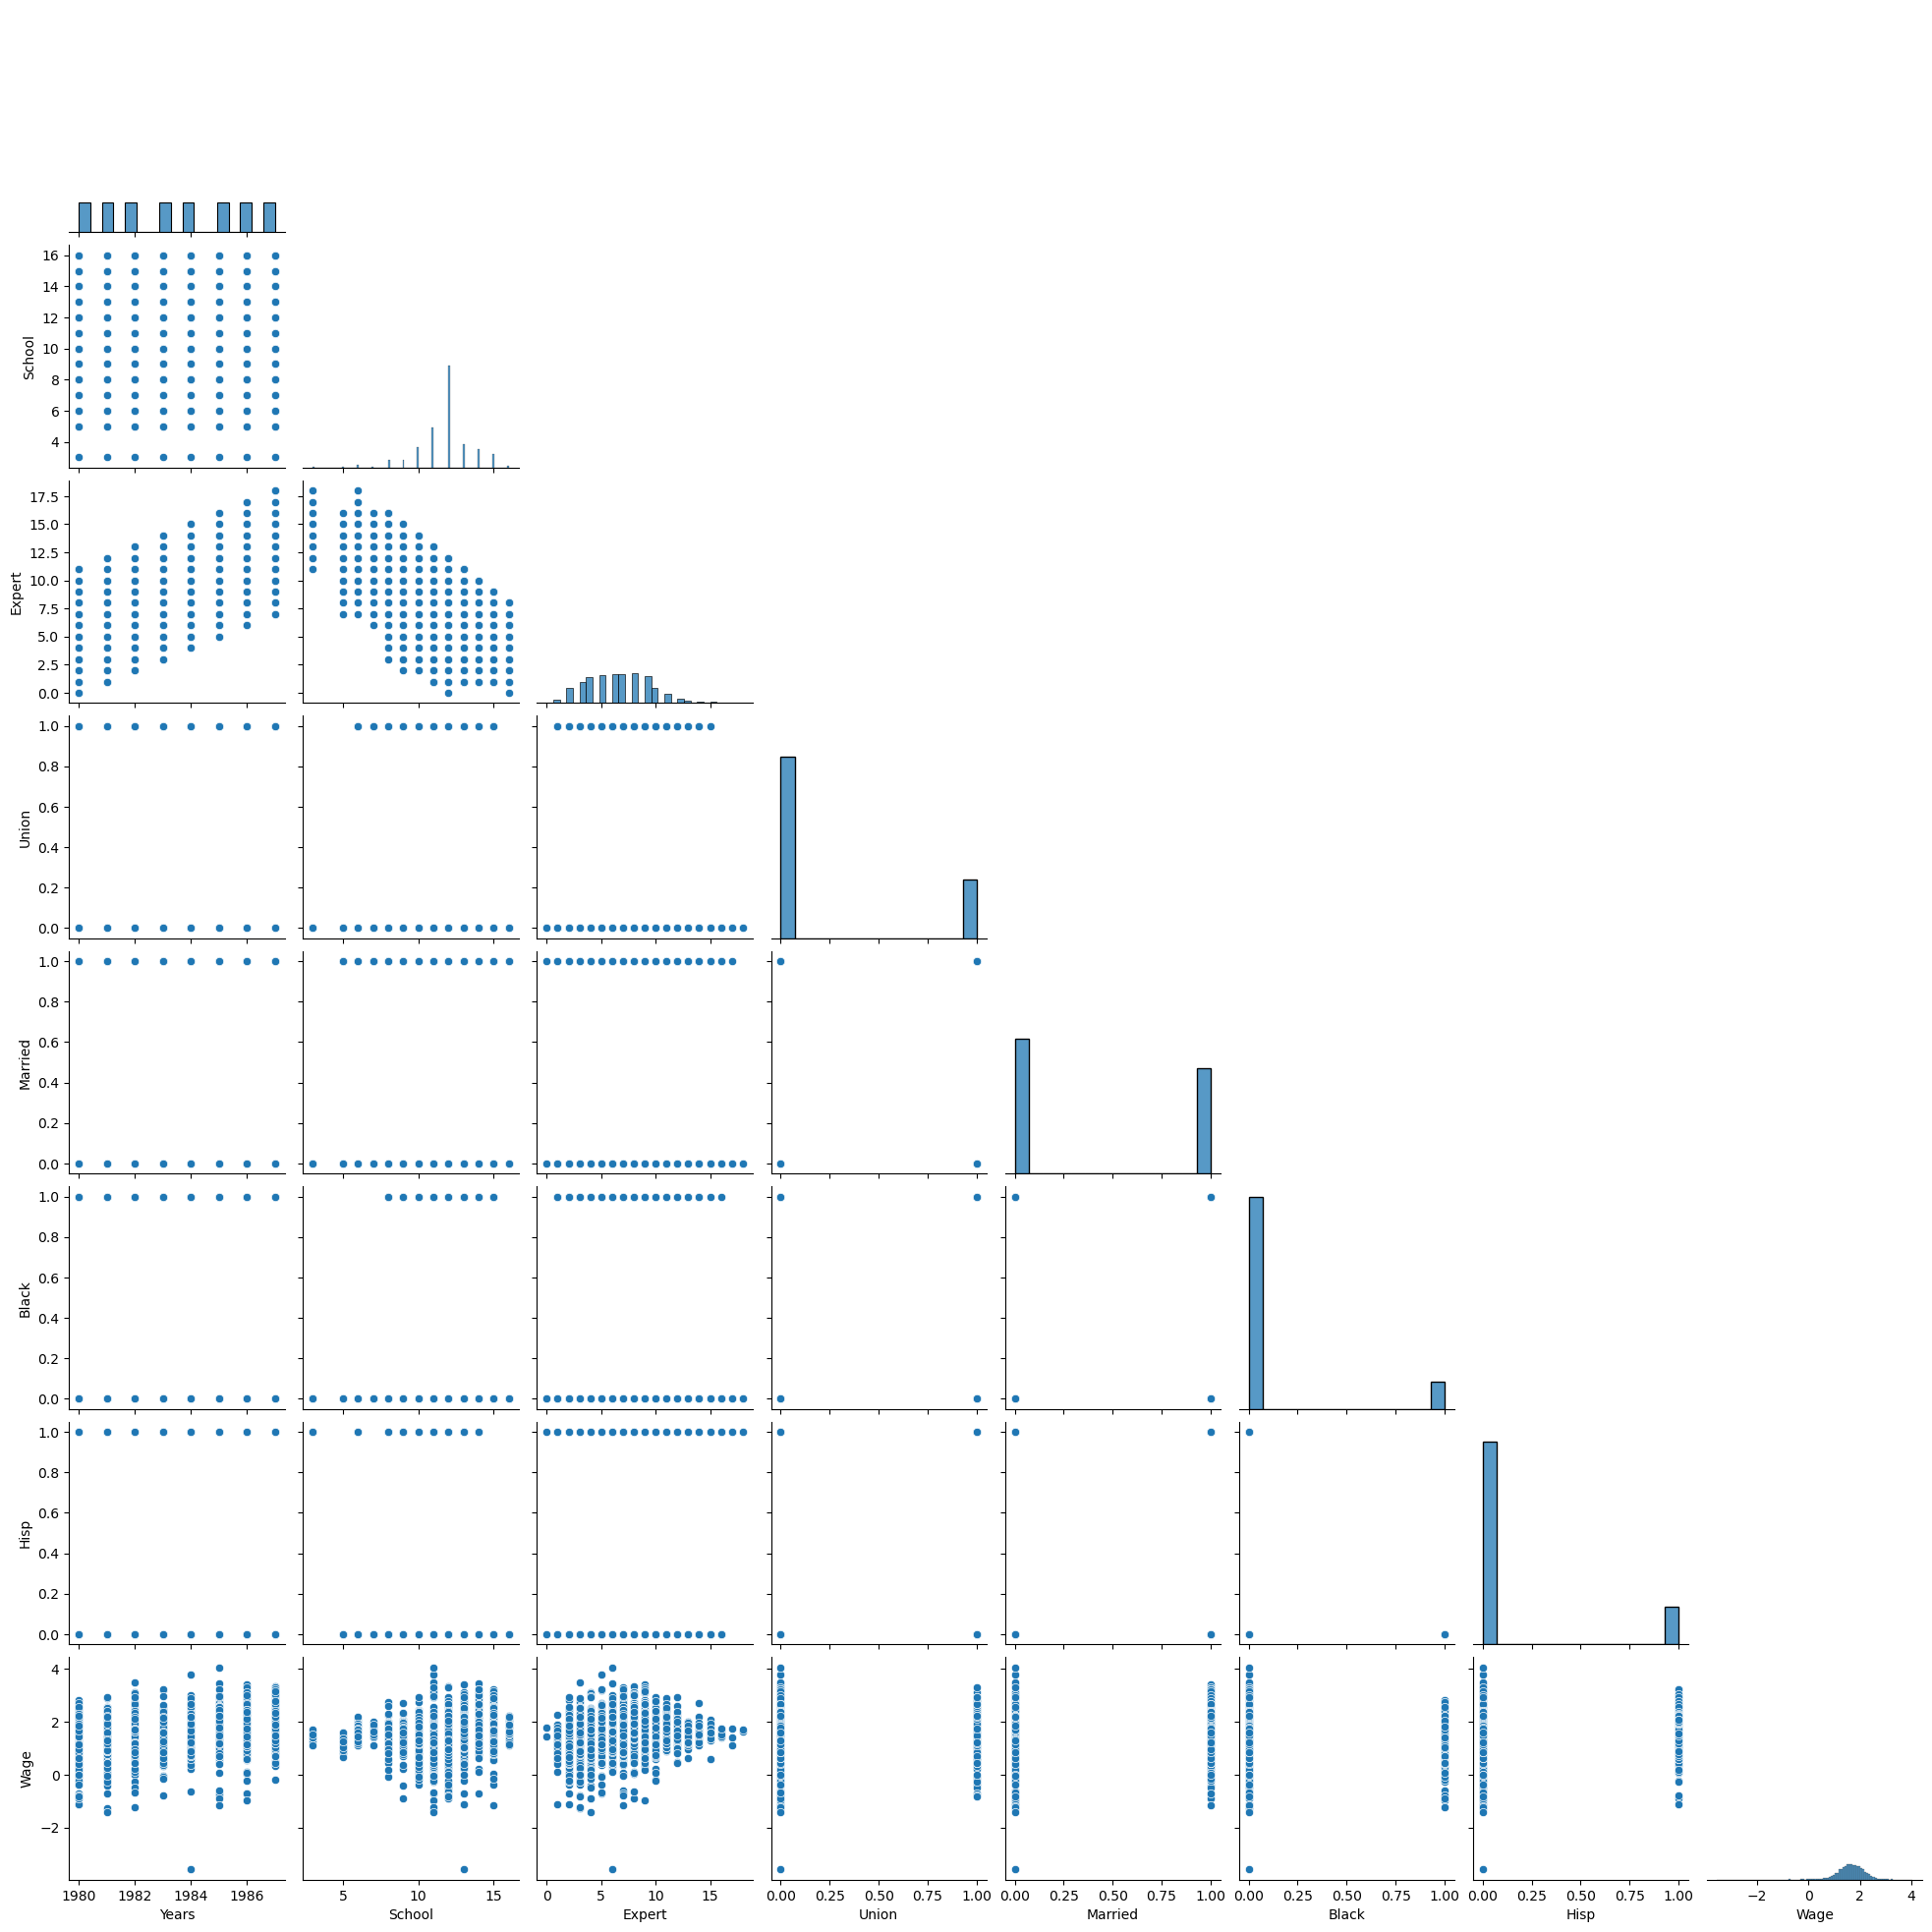

In [40]:
sns.pairplot(males, corner=True);

In [41]:
X = males.drop(['Wage'],axis=1)
y = males['Wage']

X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.7, test_size=0.3, 
                                                    random_state = 25)
X_train.head(3)

,Years,School,Expert,Union,Married,Black,Hisp
2921,1984.0,12.0,6.0,0.0,0.0,0.0,0.0
333,1984.0,10.0,7.0,0.0,0.0,0.0,0.0
2789,1981.0,11.0,3.0,1.0,1.0,0.0,0.0


### Пишем трансформер

In [178]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["Years","Union", "Married", "Black", "Hisp"] # категориальные
numerical_columns = ["School", "Expert"]                            # числовые

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary", sparse_output=False), categorical_columns),
    remainder="passthrough",           # не выбранные дропнуть 'drop' или оставить без изменения "passthrough"
    #sparse_threshold=0,               # доля ненулевых ко всем для к разряженным матрицам, 0 - обычная матрица
    verbose_feature_names_out= False,  # добавлять префикс с именем преобразователя, который сгенерировал этот объект
    force_int_remainder_cols = False,  # сохранить имена колонок True, назначить числа False ??? пока не ясно как работает
).set_output(transform="pandas")

preprocessor.fit_transform(X_train)

,Years_1980.0,Years_1981.0,Years_1982.0,Years_1983.0,Years_1984.0,Years_1985.0,Years_1986.0,Years_1987.0,Union_1.0,Married_1.0,Black_1.0,Hisp_1.0,School,Expert
2921,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,6.0
333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,7.0
2789,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,11.0,3.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,9.0
123,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,13.0,6.0
255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,9.0
2934,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,11.0,5.0
2191,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.0,3.0


In [180]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.pipeline import make_pipeline, Pipeline

model_test = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator',    LinearRegression()),
])

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

param_grid =[
    {'preprocessor': [preprocessor],
     'estimator': [LinearRegression(n_jobs=-1)], 
    },
    {'preprocessor': [preprocessor],
     'estimator': [Ridge()],
     'estimator__alpha':[0.001,0.01]
    },
    {'preprocessor': [preprocessor],
     'estimator': [Lasso()],
     'estimator__alpha':[0.00001, 0.0001]
    },
    ]

grid = GridSearchCV(model_test, param_grid, cv = cv, return_train_score = True)
grid.fit(X_train, y_train)
grid

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       sparse_output=False),
                                                                         ['Years',
                                                                          'Union',
                                                                          'Married',
                                                                          'Black',
                                                                          'Hisp'])],
                                                          verbose_feature_names_out=False)),
                                       ('e...
                                                             verbose_feature_names_out=False)]},
                         {'estimator': [Lasso()],
                          'estimator__alpha': [1e-05, 0.0001],
                          'preprocessor': [ColumnTransformer(force_int_remainder_cols=False,
                                                             remainder='passthrough',
                                                             transformers=[('onehotencoder',
                                                                            OneHotEncoder(drop='if_binary',
                                                                                          sparse_output=False),
                                                                            ['Years',
                                                                             'Union',
                                                                             'Married',
                                                                             'Black',
                                                                             'Hisp'])],
                                                             verbose_feature_names_out=False)]}],
             return_train_score=True)

In [181]:
pd.DataFrame(grid.cv_results_)[['param_estimator', 'param_estimator__alpha',
                                'mean_train_score', 'std_train_score', 
                                'mean_test_score', 'std_test_score']]

,param_estimator,param_estimator__alpha,mean_train_score,std_train_score,mean_test_score,std_test_score
0,LinearRegression(n_jobs=-1),NaN,0.195902,0.004964,0.184037,0.020732
1,Ridge(),0.00100,0.195937,0.004950,0.184080,0.020754
2,Ridge(),0.01000,0.195937,0.004950,0.184081,0.020753
3,Lasso(),0.00001,0.195937,0.004950,0.184086,0.020750
4,Lasso(),0.00010,0.195930,0.004950,0.184130,0.020724


Анализ данных результатов нам показывает, что в модели все фичи значимы для построения модели, а дальнейшее увеличение силы регуляризации практически не будет менять L2-регрессию и ухудшать L1-регрессию. 

Необходимо отметить, что с точки зрения ML все модели обладают крайне низким предсказательным потенциалом, поэтому они бесполезны с точки зрения решения «классических задач» машинного обучения. Если нужно вытянуть предсказательный потенциал данной модели, то описанное ниже решение для этого не подходит. 

## Рассмотрим простую LR
можно потом заменить на Lasso

In [205]:
model = make_pipeline(
    preprocessor,
    LinearRegression(n_jobs=-1),
)

In [207]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['Years', 'Union', 'Married',
                                                   'Black', 'Hisp'])],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [209]:
X_train

,Years,School,Expert,Union,Married,Black,Hisp
2921,1984.0,12.0,6.0,0.0,0.0,0.0,0.0
333,1984.0,10.0,7.0,0.0,0.0,0.0,0.0
2789,1981.0,11.0,3.0,1.0,1.0,0.0,0.0
45,1987.0,10.0,9.0,0.0,0.0,0.0,0.0
123,1985.0,12.0,9.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
1175,1982.0,13.0,6.0,1.0,1.0,0.0,0.0
255,1985.0,12.0,9.0,0.0,0.0,0.0,0.0
2934,1983.0,11.0,5.0,1.0,0.0,1.0,0.0
2191,1981.0,11.0,3.0,1.0,0.0,0.0,0.0


In [211]:
y_pred = model.predict(X_test)
model.score(X_test,y_test)

0.1678213928710337

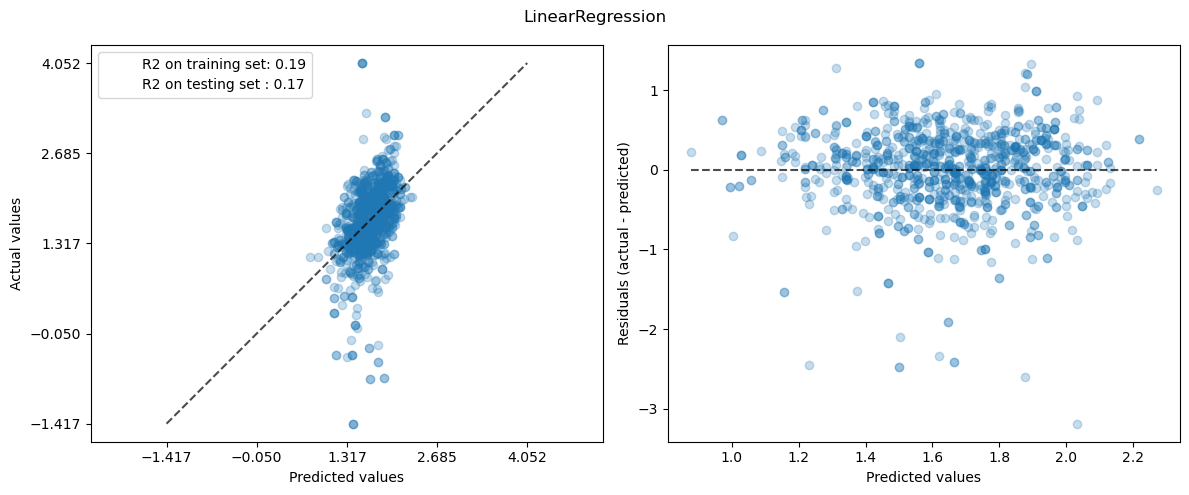

In [213]:
import matplotlib.pyplot as plt


r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)
scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("LinearRegression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

Мы видим явное «смешение» на тестовом наборе (левый график). В идеале точки должны были разместиться на черной пунктирной линии. Исправить ситуацию можно, но в ущерб интерпретируемости результатов, поэтому оставляем как есть.

Найдем значения коэффициентов в модели и их разброс, и визуализируем результат

In [195]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    {"Coefficients": model[-1].coef_ , 
     'Std': model[:-1].transform(X_train).std(axis=0).values},
     index=feature_names    
)

coefs

,Coefficients,Std
Years_1980.0,-0.157907,0.327965
Years_1981.0,-0.031964,0.332069
Years_1982.0,-0.014886,0.327965
Years_1983.0,-0.030970,0.329093
Years_1984.0,0.033825,0.330587
Years_1985.0,0.045206,0.330959
Years_1986.0,0.074246,0.334634
Years_1987.0,0.082450,0.332806
Union_1.0,0.178703,0.427456
Married_1.0,0.091681,0.496513


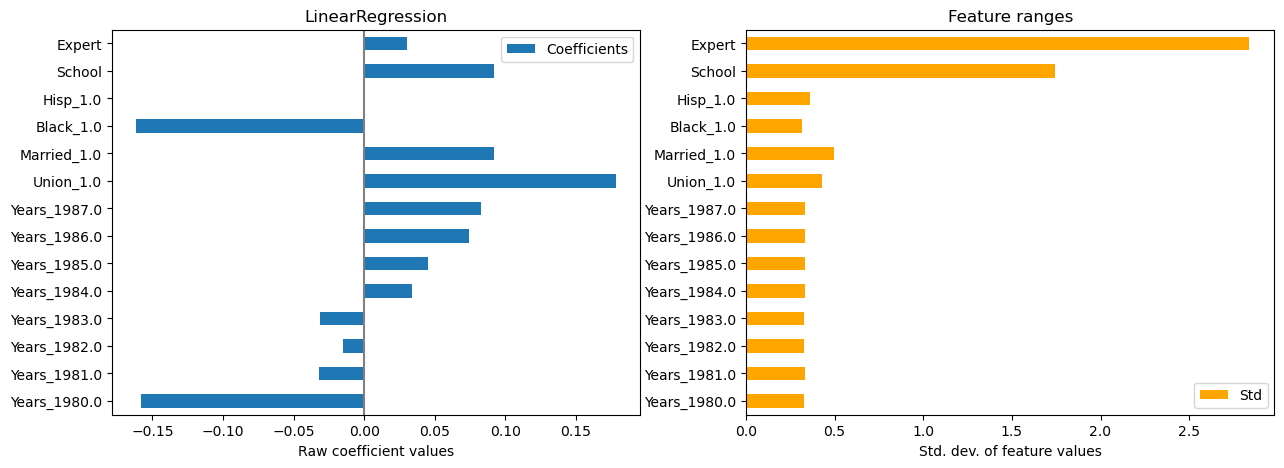

In [197]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
coefs['Coefficients'].plot.barh(ax=axs[0])
axs[0].set_title("LinearRegression")
axs[0].axvline(x=0, color=".5")
axs[0].set_xlabel("Raw coefficient values");
axs[0].legend();
coefs['Std'].plot.barh(ax=axs[1], color='orange')
axs[1].set_title("Feature ranges")
axs[1].set_xlabel("Std. dev. of feature values")
axs[1].legend();

Однако в данном результате есть некоторая неточность. В чем же она заключается. Мы используем величины разной размерности, поэтому нам нужно стандартизировать результаты. Обычно это делается до обучения модели, но тогда страдает интерпретируемость результата, поэтому поступим следующим образом: умножим коэффициенты на стандартное отклонение соответствующего признака, что приведет значения всех коэффициентов к одной и той же единице измерения

$$y =  \sum_{i=1}^m w\cdot x_i = \sum_{i=1}^m (w^{(j)} \times std(w^{(j)}) \dfrac{ x_i}{std(w^{(j)})}$$

Таким образом, мы показываем, что чем больше дисперсия признака, тем больше вес соответствующего коэффициента в выходных данных при прочих равных условиях.

Итак, найдем величины стандартных отклонений в каждом столбце признаков


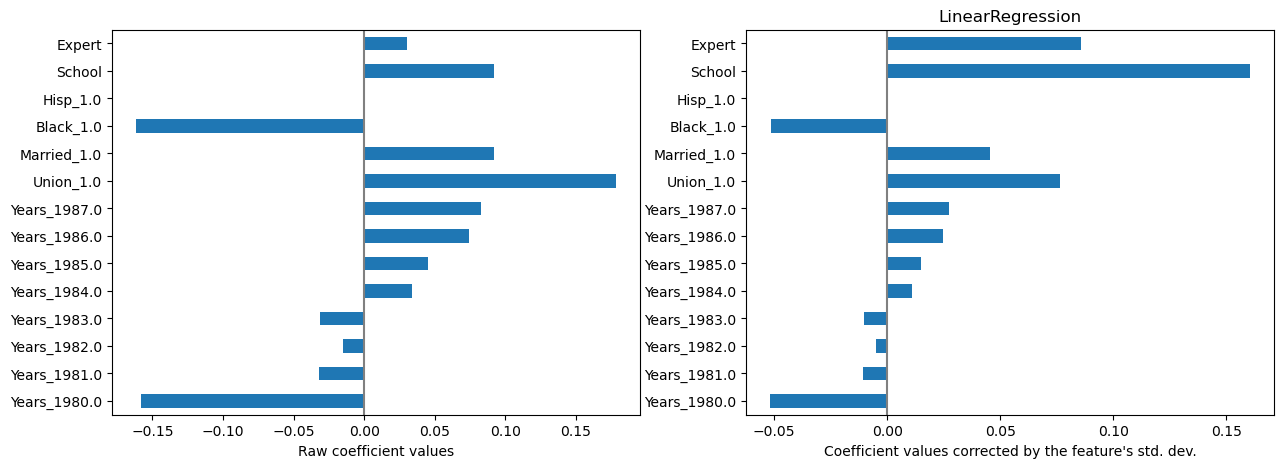

In [237]:
coefs["Coefficient importance"] = coefs['Coefficients']*coefs['Std']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
coefs['Coefficients'].plot.barh(ax=axs[0])
axs[0].axvline(x=0, color=".5")
axs[0].set_xlabel("Raw coefficient values");


coefs["Coefficient importance"].plot.barh(ax=axs[1])
axs[1].set_xlabel("Coefficient values corrected by the feature's std. dev.")
axs[1].axvline(x=0, color=".5")
plt.title("LinearRegression");

Теперь возьмем все данные и проведем кросвалидацию наших решений и посмотрим, насколько «стабильны» и корректны наши решения.

In [240]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=-1,
)

In [241]:
### нужно объяснить этот код
coefs = pd.DataFrame(
    [
        est[-1].coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y)) # cv.split возвращает индексы строк train и test
    ],
    columns=feature_names,
)
coefs.tail(3)

,Years_1980.0,Years_1981.0,Years_1982.0,Years_1983.0,Years_1984.0,Years_1985.0,Years_1986.0,Years_1987.0,Union_1.0,Married_1.0,Black_1.0,Hisp_1.0,School,Expert
22,-0.034170,-0.014345,-0.003211,-0.008598,0.006417,0.015114,0.013387,0.024943,0.082893,0.061873,-0.042100,0.005501,0.170198,0.096635
23,-0.043837,-0.013799,-0.011276,-0.006248,0.008483,0.012375,0.025863,0.028865,0.077933,0.045416,-0.049073,0.008605,0.158817,0.086186
24,-0.045762,-0.008798,-0.006580,-0.002288,0.002970,0.009638,0.020977,0.030203,0.079624,0.053967,-0.041271,0.005291,0.162466,0.090563


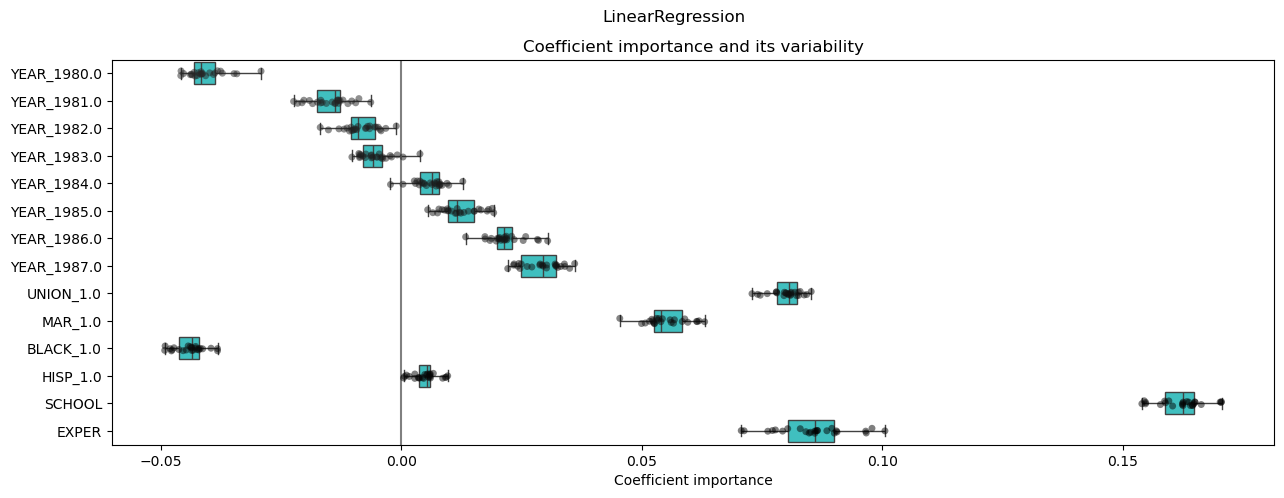

In [164]:
plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("LinearRegression");

«Коробочки» получились без визуальных аномалий и выбросов, что позволяет не делать дальнейшие шаги по решению проблем с мультиколлениарностью.
Получили (после потенцирования результата), что работник, состоявший в профсоюзе в среднем, получает больше на:

In [170]:
mu_union = np.exp(coefs['UNION_1.0'].mean())
std_union = np.exp(coefs['UNION_1.0'].std())
print('mu ± std : ', round((mu_union-1)*100,2), '±', round((std_union-1)*100,2),'%')

mu ± std :  8.33 ± 0.31 %


Кстати, а почему мы потенциировали результат, а не взяли тот который получился? 

In [168]:
coefs['UNION_1.0'].mean()

0.08002582218900266